# Conditional Flow Matching (CFM)

A simple tutorial of Conditional Flow Matching (CFM) [Lipman22] using MNIST dataset.

Author: Minsu Kang

Email: mskang1478@gmail.com

In [2]:
import torch, os
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

from torch.optim import AdamW

In [3]:
import os
# Set CUDA_VISIBLE_DEVICES before importing torch
os.environ['CUDA_VISIBLE_DEVICES'] = "0"  # or whichever GPU you want to use
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

from torch.optim import AdamW

dataset_path = '~/datasets'

dataset = "MNIST"
# Remove gpu_id and cuda variables for clarity

hidden_dim = 256
n_layers = 8

lr = 5e-5
sigma_min = 0

n_epochs = 200
train_batch_size = 128

inference_batch_size = 64

seed = 1234

# Use robust device selection
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)
hidden_dims = [hidden_dim for _ in range(n_layers)]

torch.manual_seed(seed)
np.random.seed(seed)


## Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

## Step 2. Define our model: Conditional Flow Matching (CFM)

In this tutorial, we use **Example-2: Optimal Transport conditional Vector Fields** which is proposed in the paper.

For comparison, we use a simple stacked-convolution model with various dilations as like [Denoising Diffusion Probabilistic Model(DDPM) tutorial](https://github.com/Jackson-Kang/Pytorch-Diffusion-Model-Tutorial). The number of trainable parameters and other details are almost same.

In [5]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

In [6]:
class Model(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], sigma_min=0.):
        super(Model, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(1, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[1], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        self.sigma_min = sigma_min

    def get_velocity(self, x_0, x_1):        
        """
            Target velocity (or vector field). 
                This vector field generates conditional probabilistic path 
                    that maps a sampled noise from Gaussian normal to target data distribution
        """
        return (x_1 - (1-self.sigma_min) * x_0)
    
    def interpolate(self, x_0, x_1, t):
        """
            Conditional flow, psai_t(x_0) that corresponds to u_t(x | x_1).
                Since we use Optimal Transport conditional VFs, 
                    we simply use linear interpolation between noise(x_0) and target sample(x_1).
        """
        return (1 - (1-self.sigma_min) * t) *  x_0 + t * x_1
    
    
    def forward(self, x, t):
        """
            Estimate vector field given x_t and time embedding.
        """
        
        time_embedding = self.time_project(t)
        y = self.in_project(x)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, time_embedding, residual=True)
            
        v_t = self.out_project(y)
        return v_t

    @torch.no_grad()
    def sample(self, t_steps, shape, DEVICE):

        """
            move x_0 (located in noise distribution) to x_1 (located in target data distribution)
        """

        B, C, W, H = shape
        
        x_0 = torch.randn(size=shape, device=DEVICE)
        t_vals = torch.linspace(0, 1, t_steps, device=DEVICE)
        delta = 1.0 / (t_steps - 1)

        x_1_hat = x_0
        for i in range(t_steps - 1):
            t_cur = t_vals[i].view(-1, 1, 1, 1)
            velocity_pred = self(x_1_hat, t_cur)
            x_1_hat = x_1_hat + velocity_pred * delta
            
        return x_1_hat

    
model = Model(image_resolution=img_size,
                 hidden_dims=hidden_dims, sigma_min=sigma_min).to(DEVICE)

In [7]:
optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.99))

## Step 3. Train Conditional Flow Matching(CFM).

Start training CFM...
		CFM loss:  0.0935225859284401   grad_norm: 1.5555553899612278
		CFM loss:  0.10697339475154877   grad_norm: 5.1263623791746795
		CFM loss:  0.09580972045660019   grad_norm: 2.5543786315247416
		CFM loss:  0.11191830784082413   grad_norm: 3.078716572606936
		CFM loss:  0.09855922311544418   grad_norm: 4.653894734103233
	Epoch 1 complete! 	CFM Loss:  0.09858686219591067
		CFM loss:  0.09312394261360168   grad_norm: 2.0592874897411093
		CFM loss:  0.08900994807481766   grad_norm: 2.9611666942946613
		CFM loss:  0.10256878286600113   grad_norm: 2.8341749478131533
		CFM loss:  0.0966188833117485   grad_norm: 2.572110438486561
		CFM loss:  0.09328769892454147   grad_norm: 2.043686385033652
	Epoch 2 complete! 	CFM Loss:  0.09888669754714091
		CFM loss:  0.0980294868350029   grad_norm: 1.3220118004828691
		CFM loss:  0.09563148766756058   grad_norm: 2.951280714944005
		CFM loss:  0.0958494022488594   grad_norm: 3.017381852027029
		CFM loss:  0.10394559055566788   grad_n

KeyboardInterrupt: 

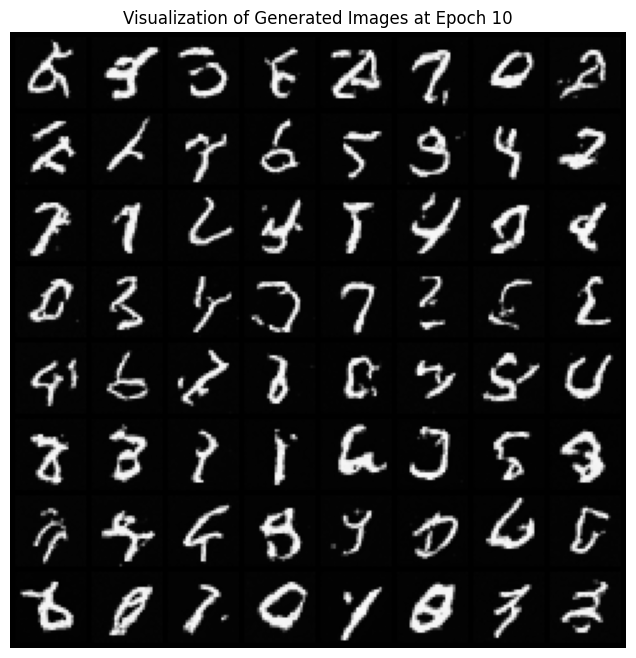

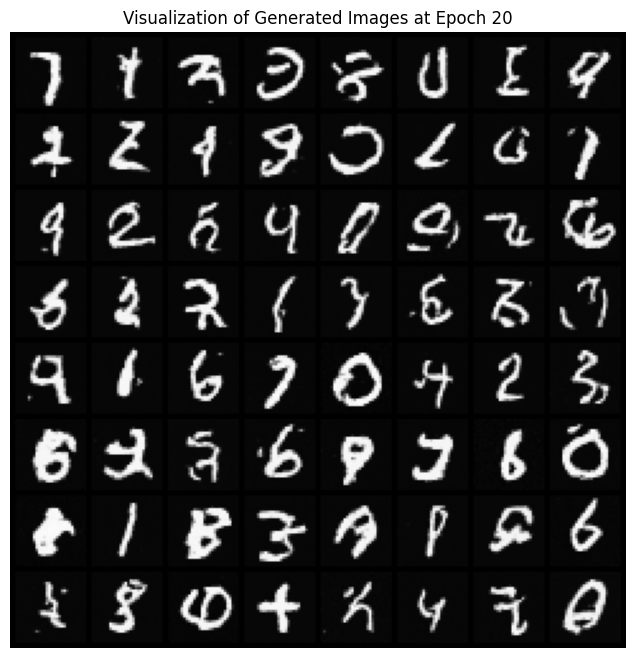

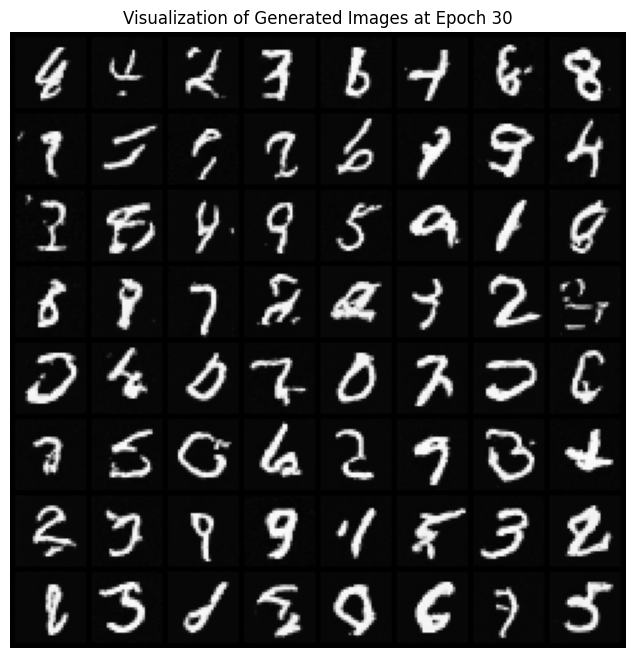

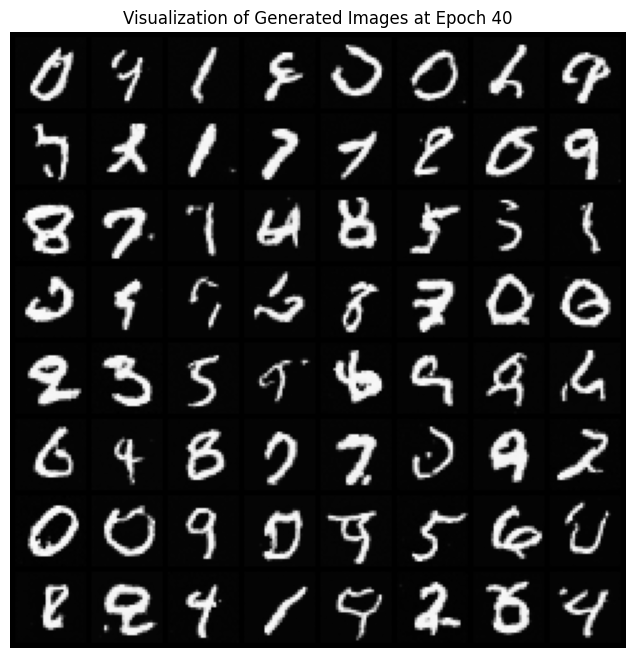

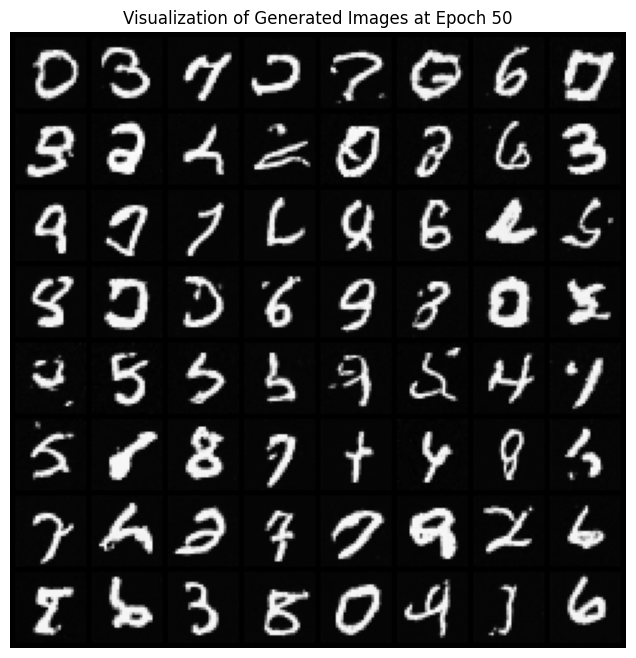

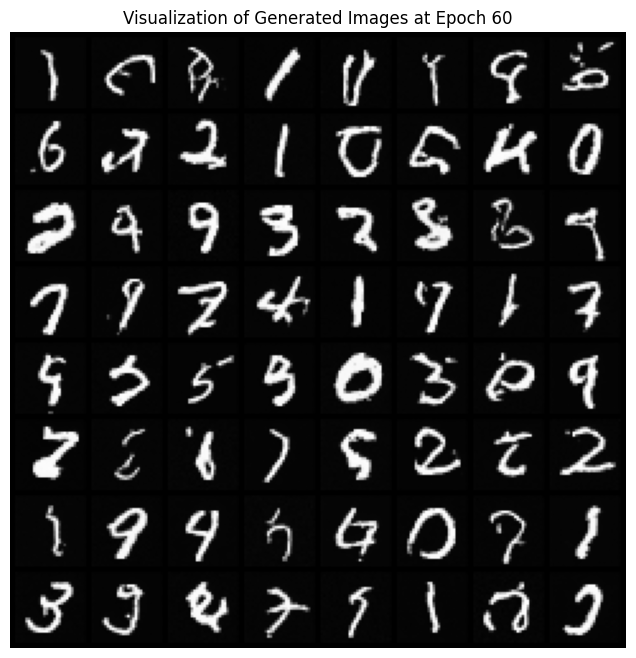

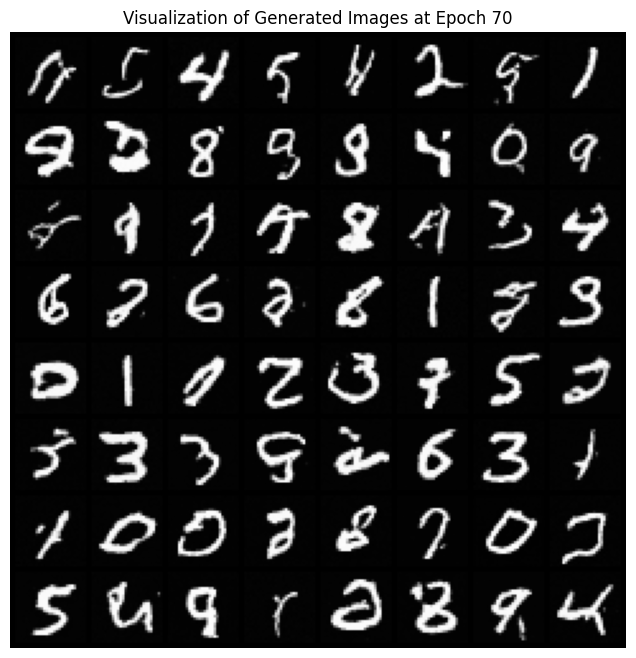

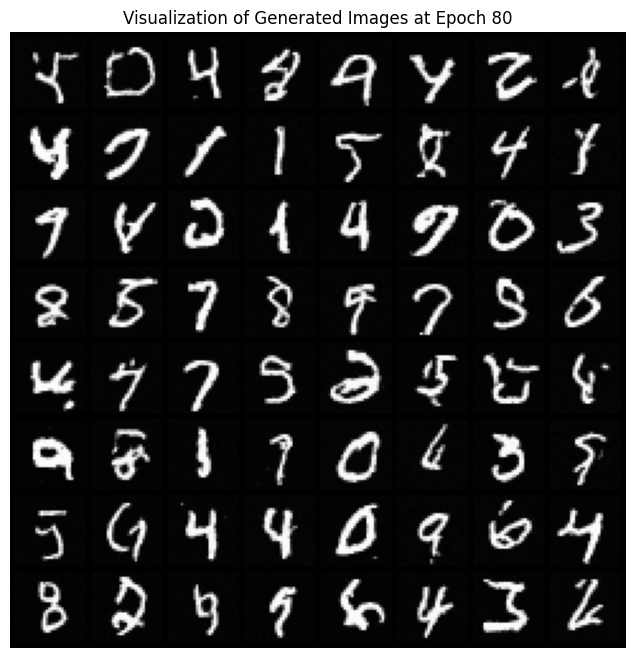

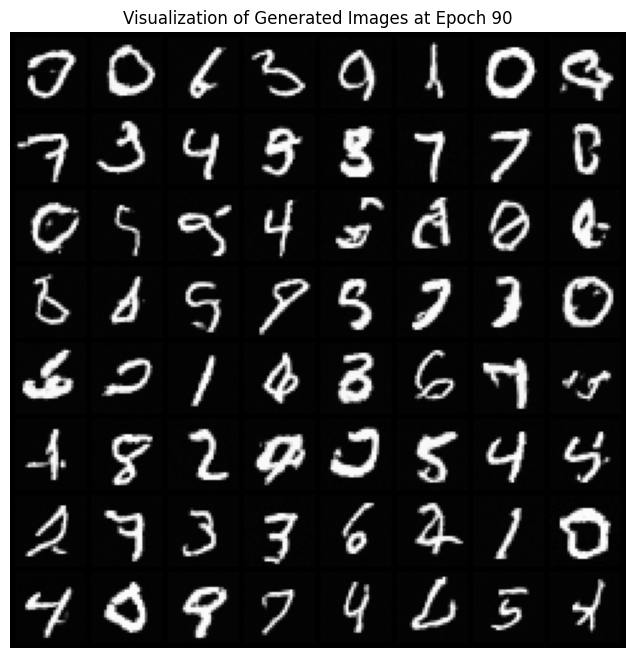

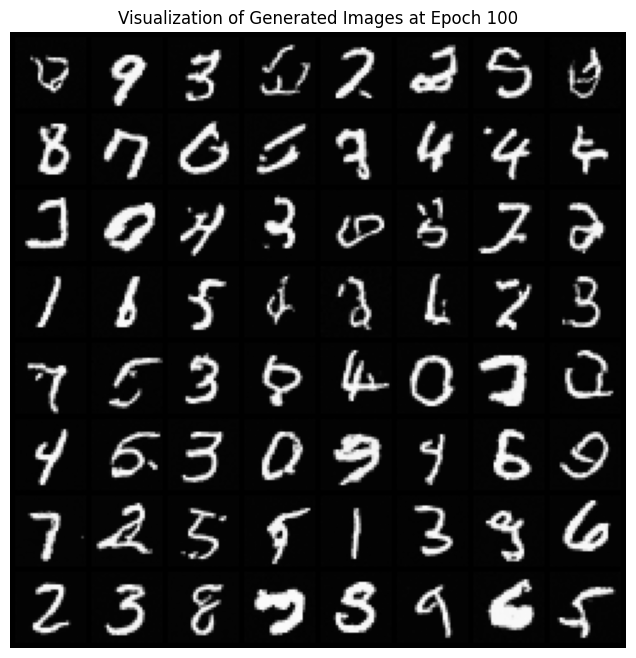

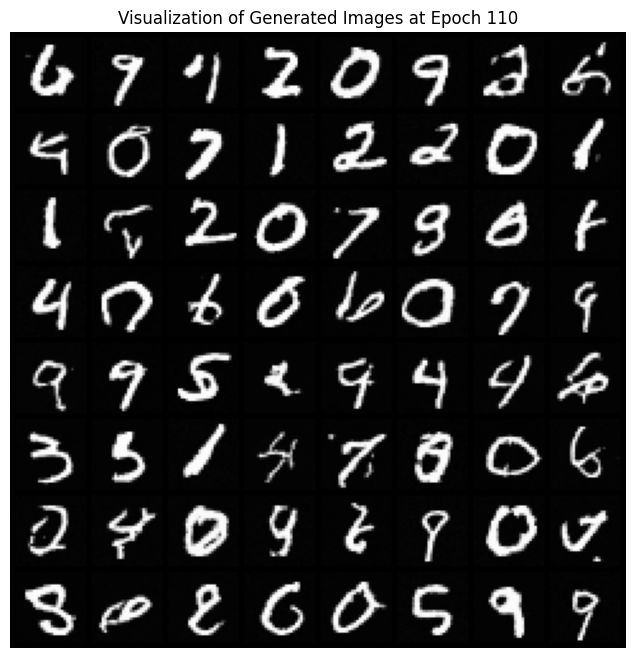

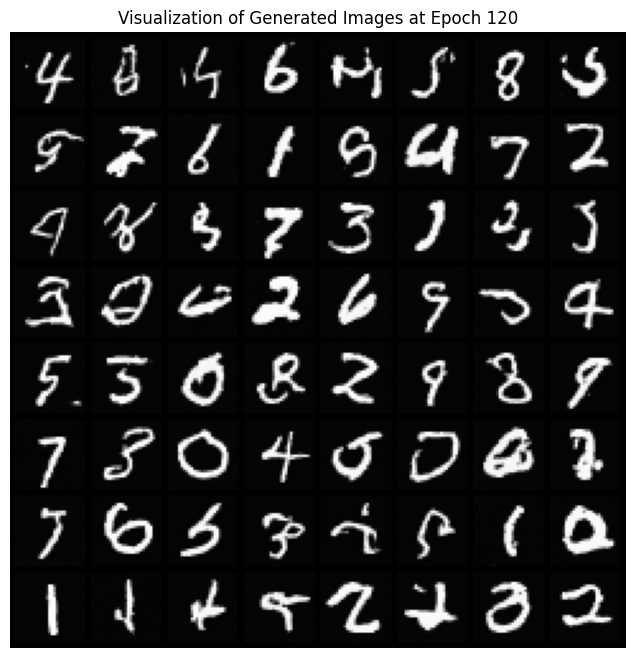

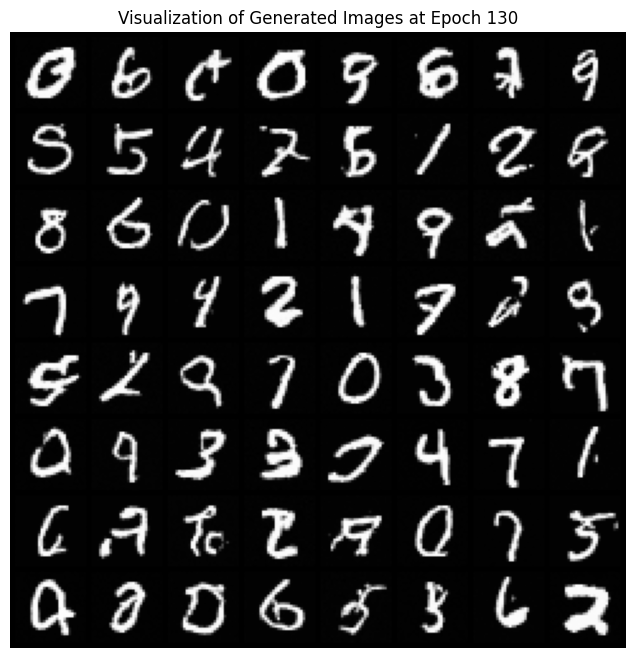

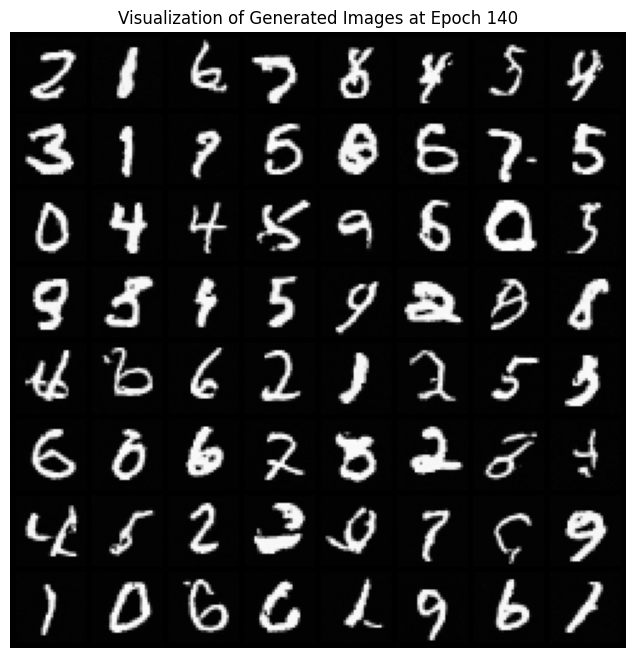

In [10]:
print("Start training CFM...")
model.train()
n_epochs = 500
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))
for epoch in range(n_epochs):
    total_loss = 0
    for batch_idx, (x_1, _) in enumerate(train_loader):
        optimizer.zero_grad()

        # sample Gaussian normal and target data
        x_1 = x_1.to(DEVICE)
        x_0 = torch.randn_like(x_1)
        t = torch.rand(x_1.shape[0], 1, 1, 1, device=DEVICE)

        # get noise-interpolated data
        x_t = model.interpolate(x_0, x_1, t)

        # target velocity
        velocity_target = model.get_velocity(x_0, x_1)
        # estimate velocity
        velocity_pred = model(x_t, t)

        # conditional flow matching loss. model learns 
        loss = ((velocity_pred - velocity_target) ** 2).mean()
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)

        if batch_idx % 100 == 0:
            print("\t\tCFM loss: ", loss.item(), "  grad_norm:", grad_norm)
        
    print("\tEpoch", epoch + 1, "complete!", "\tCFM Loss: ", total_loss / len(train_loader))
    
    # Plot generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        B = inference_batch_size
        W, H, C = img_size
        inference_n_flows = 50
        x_hats = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)
        draw_sample_image(x_hats, f"Generated Images at Epoch {epoch + 1}")

print("Finish!!")

# Step 4. Generate sample from Trained CFM Model

In [8]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

In [9]:
model.eval()

B = 1
W, H, C = img_size

### Exploring optimal value of the # of conditional flow, $T$

#### Generation result when $T=2$

In [10]:
inference_n_flows = 2
x_hats_02 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

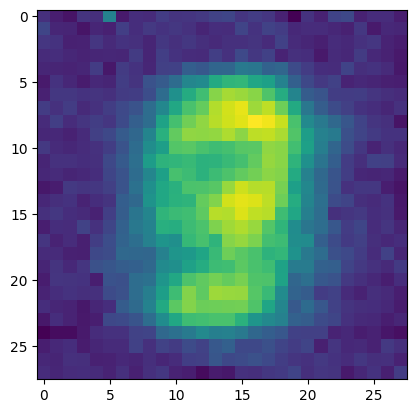

In [11]:
show_image(x_hats_02, 0)

#### Generation result when $T=5$

In [12]:
inference_n_flows = 5
x_hats_05 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

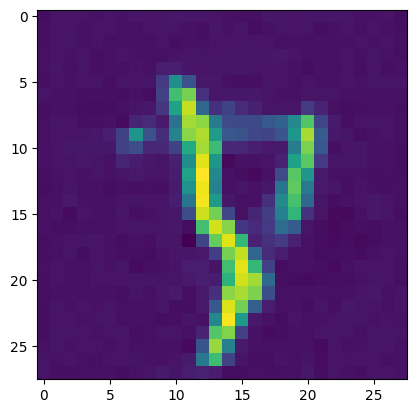

In [13]:
show_image(x_hats_05, 0)

#### Generation result when $T=10$

In [14]:
inference_n_flows = 10
x_hats_10 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

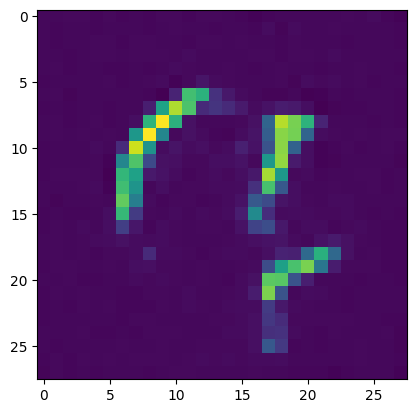

In [15]:
show_image(x_hats_10, 0)

#### Generation result when $T = 25$

In [16]:
inference_n_flows = 25
x_hats_25 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

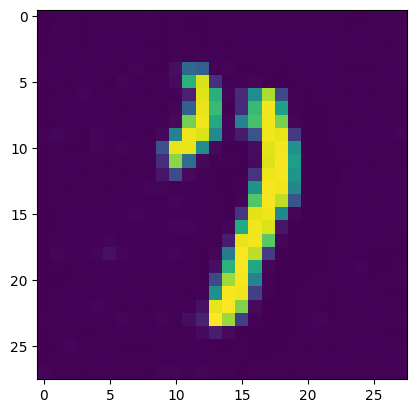

In [17]:
show_image(x_hats_25, 0)

#### Generation result when $T = 50$

In [18]:
inference_n_flows = 50
x_hats_50 = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

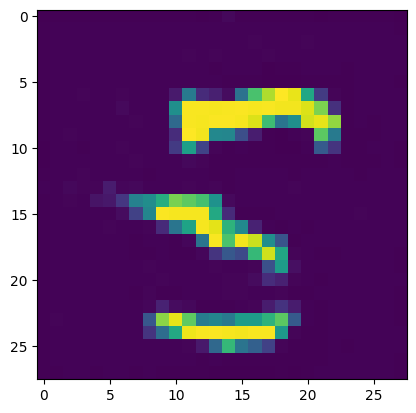

In [19]:
show_image(x_hats_50, 0)

### Comparison with Ground-truth Samples

In [20]:
B = inference_batch_size
inference_n_flows = 50
x_hats = model.sample(inference_n_flows, shape=[B, C, W, H], DEVICE=DEVICE)

In [21]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

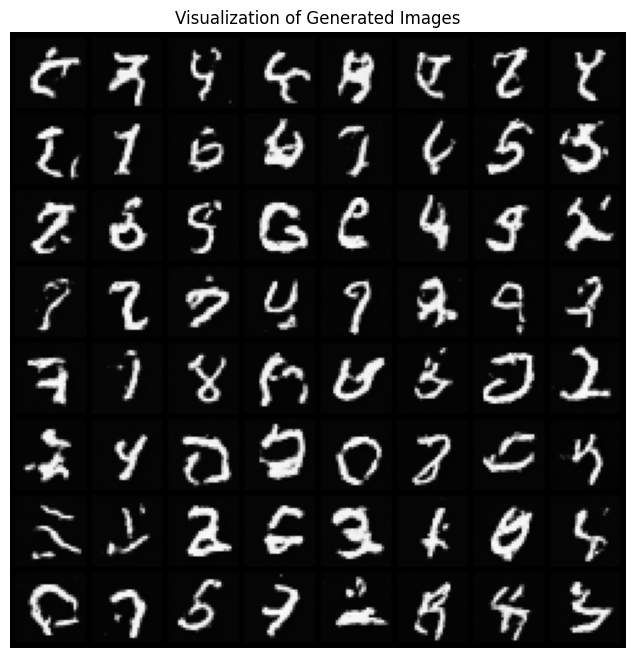

In [22]:
draw_sample_image(x_hats, "Generated Images")

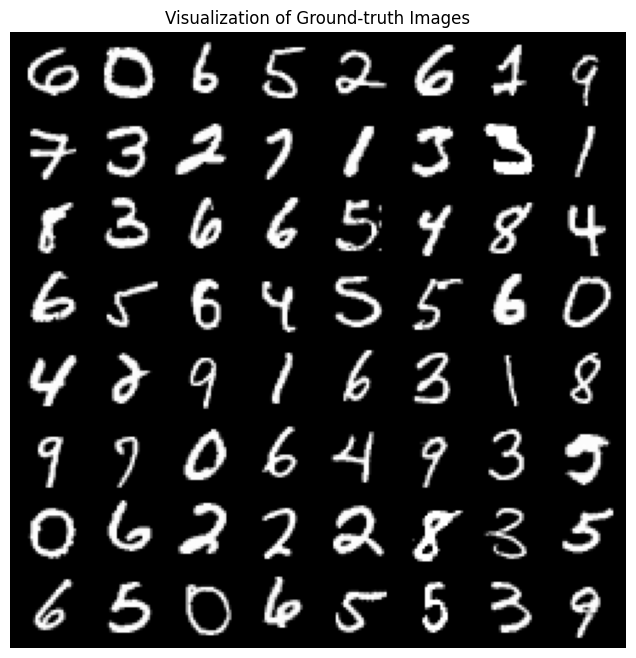

In [23]:
draw_sample_image(x_1[:inference_batch_size], "Ground-truth Images")

## References

* [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366), Chen et. al., 2018
* [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), J. Ho et. al., 2020
* [Flow Matching for Generative Modeling](https://arxiv.org/abs/2210.02747), Lipman et. al., 2022